In [1]:
using ScikitLearn
using Statistics
using Plots
using Printf
using Random

@sk_import datasets: (make_circles, make_moons, make_blobs)

PyObject <function make_blobs at 0x11bca39d8>

In [2]:
n_samples = 1500
noisy_circles = make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = make_moons(n_samples=n_samples, noise=.05)
blobs = make_blobs(n_samples=n_samples, random_state=8)

([5.8675 8.17715; 5.6137 9.93296; … ; -4.61701 -9.64856; -3.4864 -9.25767], [0, 0, 0, 1, 1, 1, 0, 1, 2, 1  …  2, 2, 0, 1, 1, 0, 2, 0, 2, 2])

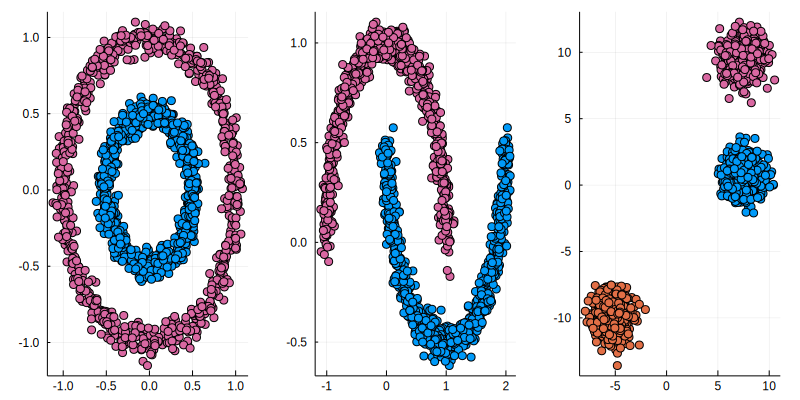

In [3]:
plts = []

for data in [noisy_circles, noisy_moons, blobs]
    points, label = data
    push!(plts, scatter(points[:, 1], points[:, 2], label="", mc=label))
end

Plots.plot(plts..., layout = (1, 3), size = [800, 400])

In [7]:
mutable struct KMean
    points::Array{Float64}
    K::Int64
    zs::Vector{Int64}
    μs::Array{Float64}
    dist::Float64
    dist_change::Float64
end

function KMean(points::Array{Float64}, K::Int64)
    n_points = size(points, 1)
    init_zs = nothing
    while true
        init_zs = rand(1:K, n_points)
        if Base.length(Set(init_zs)) == K
            break
        end
    end
    zs = init_zs
    kmean = KMean(points, K, zs, zeros(1, size(points, 2), K), 0, typemax(Float64))
    update_μs!(kmean)
    kmean
end

function update_μs!(km::KMean)
    km.μs = cat([mean(km.points[km.zs .== i, :], dims=1) for i in 1:km.K]..., dims=3)
    new_dist = sum((km.points - reshape(km.μs[:, :, km.zs], 2, :)').^2)
    km.dist_change = km.dist - new_dist
    km.dist = new_dist
    km
end

function update_zs!(km::KMean)
    norms = sum((km.points .- km.μs).^2, dims=2)
    argmin_norms = [x[3] for x in argmin(norms, dims=3)][:]
    
    while true
        if Base.length(Set(argmin_norms)) == km.K
            break
        end
        argmin_norms = rand(1:km.K, size(km.points, 1))
    end
    
    km.zs = argmin_norms
    km
end

function update!(km::KMean)
    update_zs!(km)
    update_μs!(km)
    km
end

update! (generic function with 1 method)

In [8]:
gifs = []

for (i, (data, K)) in enumerate(zip([noisy_circles, noisy_moons, blobs], [2, 2, 3]))
    points, label = data

    km = KMean(points, K)

    anim = @animate for n=1:100
        if abs(km.dist_change) < 0.01
            break
        end
        scatter(km.points[:, 1], km.points[:, 2], mc=km.zs, label="")
        plt = scatter!(km.μs[1, 1, :], km.μs[1, 2, :], ms=8, mc=:yellow, msw=3, label="", 
                       title=@sprintf("Iterations=%d", n))
        update!(km)
        plt
    end

    push!(gifs, gif(anim, @sprintf("clustering-kmean_%d.gif", i), fps = 1))
end

┌ Info: Saved animation to 
│   fn = /Users/apple/Documents/notebook_blog/clustering-kmean_1.gif
└ @ Plots /Users/apple/.julia/packages/Plots/47Tik/src/animation.jl:90
┌ Info: Saved animation to 
│   fn = /Users/apple/Documents/notebook_blog/clustering-kmean_2.gif
└ @ Plots /Users/apple/.julia/packages/Plots/47Tik/src/animation.jl:90
┌ Info: Saved animation to 
│   fn = /Users/apple/Documents/notebook_blog/clustering-kmean_3.gif
└ @ Plots /Users/apple/.julia/packages/Plots/47Tik/src/animation.jl:90


In [9]:
display.(gifs);

Plots.AnimatedGif("/Users/apple/Documents/notebook_blog/clustering-kmean_1.gif")

Plots.AnimatedGif("/Users/apple/Documents/notebook_blog/clustering-kmean_2.gif")

Plots.AnimatedGif("/Users/apple/Documents/notebook_blog/clustering-kmean_3.gif")